In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.optim import Adam, SGD
from optimizers.adam_clara import Adam_CLARA
from optimizers.sgd_clara import SGD_CLARA

In [2]:
noise_std = 0.1

def sphere(x):
    noise = torch.randn_like(x) * noise_std # Gaussian noise
    return torch.sum((x + noise)**2)

def ellipsoid(x):
    n = x.shape[0]
    c = torch.logspace(0, 6, steps=n, base=10, dtype=x.dtype, device=x.device)
    noise = torch.randn_like(x) * noise_std # Gaussian noise
    return torch.sum(c * (x + noise) ** 2)

def optimize(f, x0, lr0, budget, algorithm=SGD_CLARA, adapt_lr=True, unit_step_direction=True):
    x = torch.tensor(x0, requires_grad=True)
    if adapt_lr is None:
        optimizer = algorithm([x], lr=lr0)
    else:
        optimizer = algorithm([x], lr=lr0, adapt_lr=adapt_lr, unit_step_direction=unit_step_direction)

    # Keep track of candidate solutions and learning rates during optimization
    candidate_sol = []
    lr = []

    # Optimization loop
    for step in range(budget):
        optimizer.zero_grad() # Clear previous gradients
        loss = f(x) # Compute loss
        loss.backward() # Compute gradients
        optimizer.step() # Update parameters

        lr.append(optimizer.param_groups[0]['lr'])
        candidate_sol.append(x.clone().detach())

        # TODO: Collect cumulative path info

    return candidate_sol, lr

In [5]:
dim = 2
x0 = 100 * np.ones(dim)
lr0 = 1e-1
budget = 3000
adapt_lr = False
unit_step_direction = True

choice = 0

f = sphere
# f_name = r'$f_\text{sphere}$'
# f_name = r'$f_\text{elli}$'
f_name = r'$\tilde{f}_\text{sphere}$'
# f_name = r'$\tilde{f}_\text{elli}$'

if choice == 0:  # SGD_CLARA
    optimizer = SGD_CLARA
    fig_title = 'SGD'
    fig_name = 'sgd_'
elif choice == 1:  # Adam_CLARA
    optimizer = Adam_CLARA
    fig_title = 'Adam'
    fig_name = 'adam_'
else:
    optimizer = SGD
    fig_title = 'torch_Adam'
    fig_name = 'torch_adam_'

if adapt_lr:
    fig_title += ' with CLARA'
    fig_name += 'clara_'

if f == sphere:
    fig_name += 'sphere_noisy_'
else:
    fig_name += 'elli_noisy_'

fig_name += 'lr0_' + str(lr0)

candidate_sol, learning_rates = optimize(f, x0, lr0, budget, algorithm=optimizer, adapt_lr=adapt_lr, unit_step_direction=unit_step_direction)

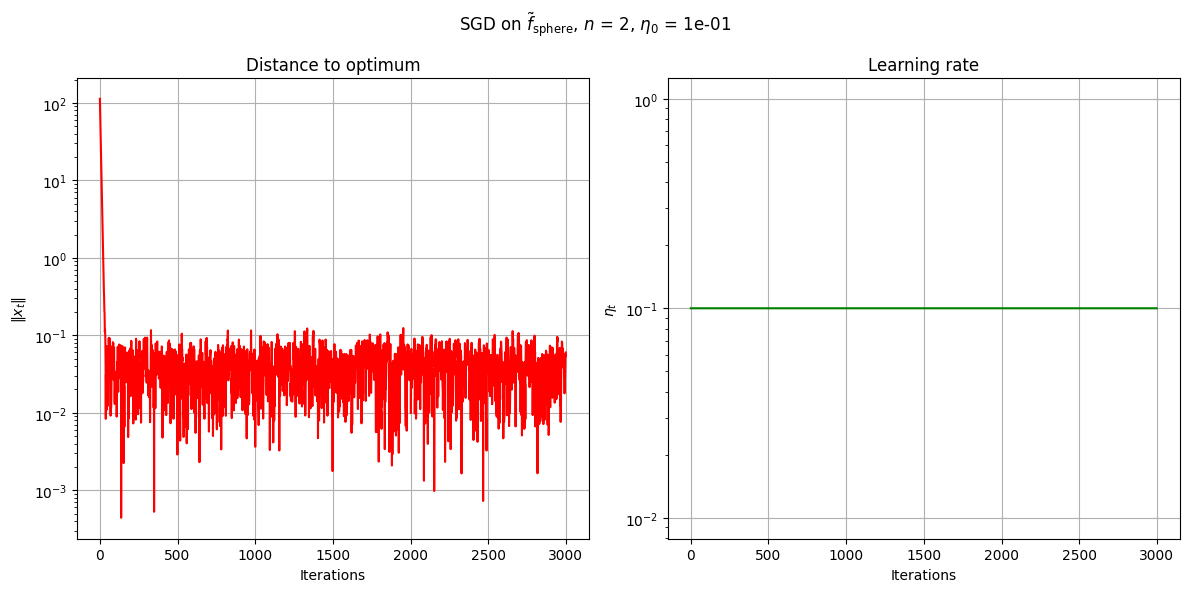

In [6]:
results = [[np.linalg.norm(x) for x in candidate_sol],
           learning_rates,
           ]
fig_titles = ['Distance to optimum',
              'Learning rate'
              ]
y_labels = [r'$\|x_t\|$',
            r'$\eta_t$'
            ]
colors = ['r',
          'g'
          ]

fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # 2 rows, 2 columns
fig.suptitle(rf'{fig_title} on {f_name}, $n$ = {str(len(x0))}, $\eta_0$ = {lr0:.0e}')

for i, ax in enumerate(axes.flat):  # Iterate over subplots
    if i < len(results):
        ax.semilogy(results[i], color=colors[i])
        ax.set_title(fig_titles[i])
        ax.set_xlabel('Iterations')
        ax.set_ylabel(y_labels[i])
        ax.grid(True)

# Adjust layout and show
plt.tight_layout()
# plt.savefig(fig_name + '.pdf')
plt.show()

In [7]:
0.2 / 2

0.1